In [25]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import random
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pathlib import Path
import pickle

def progress_bar(percentage=0, length=40, text="Progress: "):
    percentage = max(0,min(100, percentage))
    filled_blocks = int(percentage/100 * length)
    bar = "█" * filled_blocks + " " * (length - filled_blocks)
    print(text + f"[{bar}] {percentage}%", end="\r")


In [3]:
pixel_lookup_table = [(8,0), (9,0), (10,0), (11,0), (12,0), (13,0), (14,0), (15,0), (16,0), (17,0), (18,0), (19,0), (20,0), (21,0), (22,0), (23,0), (8,1), (9,1), (10,1), (11,1), (12,1), (13,1), (14,1), (15,1), (16,1), (17,1), (18,1), (19,1), (20,1), (21,1), (22,1), (23,1), (8,2), (9,2), (10,2), (11,2), (12,2), (13,2), (14,2), (15,2), (16,2), (17,2), (18,2), (19,2), (20,2), (21,2), (22,2), (23,2), (8,3), (9,3), (10,3), (11,3), (12,3), (13,3), (14,3), (15,3), (16,3), (17,3), (18,3), (19,3), (20,3), (21,3), (22,3), (23,3), (8,4), (9,4), (10,4), (11,4), (12,4), (13,4), (14,4), (15,4), (16,4), (17,4), (18,4), (19,4), (20,4), (21,4), (22,4), (23,4), (8,5), (9,5), (10,5), (11,5), (12,5), (13,5), (14,5), (15,5), (16,5), (17,5), (18,5), (19,5), (20,5), (21,5), (22,5), (23,5), (8,6), (9,6), (10,6), (11,6), (12,6), (13,6), (14,6), (15,6), (16,6), (17,6), (18,6), (19,6), (20,6), (21,6), (22,6), (23,6), (8,7), (9,7), (10,7), (11,7), (12,7), (13,7), (14,7), (15,7), (16,7), (17,7), (18,7), (19,7), (20,7), (21,7), (22,7), (23,7), (0,8), (1,8), (2,8), (3,8), (4,8), (5,8), (6,8), (7,8), (8,8), (9,8), (10,8), (11,8), (12,8), (13,8), (14,8), (15,8), (16,8), (17,8), (18,8), (19,8), (20,8), (21,8), (22,8), (23,8), (24,8), (25,8), (26,8), (27,8), (28,8), (29,8), (30,8), (31,8), (0,9), (1,9), (2,9), (3,9), (4,9), (5,9), (6,9), (7,9), (8,9), (9,9), (10,9), (11,9), (12,9), (13,9), (14,9), (15,9), (16,9), (17,9), (18,9), (19,9), (20,9), (21,9), (22,9), (23,9), (24,9), (25,9), (26,9), (27,9), (28,9), (29,9), (30,9), (31,9), (0,10), (1,10), (2,10), (3,10), (4,10), (5,10), (6,10), (7,10), (8,10), (9,10), (10,10), (11,10), (12,10), (13,10), (14,10), (15,10), (16,10), (17,10), (18,10), (19,10), (20,10), (21,10), (22,10), (23,10), (24,10), (25,10), (26,10), (27,10), (28,10), (29,10), (30,10), (31,10), (0,11), (1,11), (2,11), (3,11), (4,11), (5,11), (6,11), (7,11), (8,11), (9,11), (10,11), (11,11), (12,11), (13,11), (14,11), (15,11), (16,11), (17,11), (18,11), (19,11), (20,11), (21,11), (22,11), (23,11), (24,11), (25,11), (26,11), (27,11), (28,11), (29,11), (30,11), (31,11), (0,12), (1,12), (2,12), (3,12), (4,12), (5,12), (6,12), (7,12), (8,12), (9,12), (10,12), (11,12), (12,12), (13,12), (14,12), (15,12), (16,12), (17,12), (18,12), (19,12), (20,12), (21,12), (22,12), (23,12), (24,12), (25,12), (26,12), (27,12), (28,12), (29,12), (30,12), (31,12), (0,13), (1,13), (2,13), (3,13), (4,13), (5,13), (6,13), (7,13), (8,13), (9,13), (10,13), (11,13), (12,13), (13,13), (14,13), (15,13), (16,13), (17,13), (18,13), (19,13), (20,13), (21,13), (22,13), (23,13), (24,13), (25,13), (26,13), (27,13), (28,13), (29,13), (30,13), (31,13), (0,14), (1,14), (2,14), (3,14), (4,14), (5,14), (6,14), (7,14), (8,14), (9,14), (10,14), (11,14), (12,14), (13,14), (14,14), (15,14), (16,14), (17,14), (18,14), (19,14), (20,14), (21,14), (22,14), (23,14), (24,14), (25,14), (26,14), (27,14), (28,14), (29,14), (30,14), (31,14), (0,15), (1,15), (2,15), (3,15), (4,15), (5,15), (6,15), (7,15), (8,15), (9,15), (10,15), (11,15), (12,15), (13,15), (14,15), (15,15), (16,15), (17,15), (18,15), (19,15), (20,15), (21,15), (22,15), (23,15), (24,15), (25,15), (26,15), (27,15), (28,15), (29,15), (30,15), (31,15), (4,16), (5,16), (6,16), (7,16), (8,16), (9,16), (10,16), (11,16), (20,16), (21,16), (22,16), (23,16), (24,16), (25,16), (26,16), (27,16), (28,16), (29,16), (30,16), (31,16), (32,16), (33,16), (34,16), (35,16), (44,16), (45,16), (46,16), (47,16), (48,16), (49,16), (50,16), (51,16), (4,17), (5,17), (6,17), (7,17), (8,17), (9,17), (10,17), (11,17), (20,17), (21,17), (22,17), (23,17), (24,17), (25,17), (26,17), (27,17), (28,17), (29,17), (30,17), (31,17), (32,17), (33,17), (34,17), (35,17), (44,17), (45,17), (46,17), (47,17), (48,17), (49,17), (50,17), (51,17), (4,18), (5,18), (6,18), (7,18), (8,18), (9,18), (10,18), (11,18), (20,18), (21,18), (22,18), (23,18), (24,18), (25,18), (26,18), (27,18), (28,18), (29,18), (30,18), (31,18), (32,18), (33,18), (34,18), (35,18), (44,18), (45,18), (46,18), (47,18), (48,18), (49,18), (50,18), (51,18), (4,19), (5,19), (6,19), (7,19), (8,19), (9,19), (10,19), (11,19), (20,19), (21,19), (22,19), (23,19), (24,19), (25,19), (26,19), (27,19), (28,19), (29,19), (30,19), (31,19), (32,19), (33,19), (34,19), (35,19), (44,19), (45,19), (46,19), (47,19), (48,19), (49,19), (50,19), (51,19), (0,20), (1,20), (2,20), (3,20), (4,20), (5,20), (6,20), (7,20), (8,20), (9,20), (10,20), (11,20), (12,20), (13,20), (14,20), (15,20), (16,20), (17,20), (18,20), (19,20), (20,20), (21,20), (22,20), (23,20), (24,20), (25,20), (26,20), (27,20), (28,20), (29,20), (30,20), (31,20), (32,20), (33,20), (34,20), (35,20), (36,20), (37,20), (38,20), (39,20), (40,20), (41,20), (42,20), (43,20), (44,20), (45,20), (46,20), (47,20), (48,20), (49,20), (50,20), (51,20), (52,20), (53,20), (54,20), (55,20), (0,21), (1,21), (2,21), (3,21), (4,21), (5,21), (6,21), (7,21), (8,21), (9,21), (10,21), (11,21), (12,21), (13,21), (14,21), (15,21), (16,21), (17,21), (18,21), (19,21), (20,21), (21,21), (22,21), (23,21), (24,21), (25,21), (26,21), (27,21), (28,21), (29,21), (30,21), (31,21), (32,21), (33,21), (34,21), (35,21), (36,21), (37,21), (38,21), (39,21), (40,21), (41,21), (42,21), (43,21), (44,21), (45,21), (46,21), (47,21), (48,21), (49,21), (50,21), (51,21), (52,21), (53,21), (54,21), (55,21), (0,22), (1,22), (2,22), (3,22), (4,22), (5,22), (6,22), (7,22), (8,22), (9,22), (10,22), (11,22), (12,22), (13,22), (14,22), (15,22), (16,22), (17,22), (18,22), (19,22), (20,22), (21,22), (22,22), (23,22), (24,22), (25,22), (26,22), (27,22), (28,22), (29,22), (30,22), (31,22), (32,22), (33,22), (34,22), (35,22), (36,22), (37,22), (38,22), (39,22), (40,22), (41,22), (42,22), (43,22), (44,22), (45,22), (46,22), (47,22), (48,22), (49,22), (50,22), (51,22), (52,22), (53,22), (54,22), (55,22), (0,23), (1,23), (2,23), (3,23), (4,23), (5,23), (6,23), (7,23), (8,23), (9,23), (10,23), (11,23), (12,23), (13,23), (14,23), (15,23), (16,23), (17,23), (18,23), (19,23), (20,23), (21,23), (22,23), (23,23), (24,23), (25,23), (26,23), (27,23), (28,23), (29,23), (30,23), (31,23), (32,23), (33,23), (34,23), (35,23), (36,23), (37,23), (38,23), (39,23), (40,23), (41,23), (42,23), (43,23), (44,23), (45,23), (46,23), (47,23), (48,23), (49,23), (50,23), (51,23), (52,23), (53,23), (54,23), (55,23), (0,24), (1,24), (2,24), (3,24), (4,24), (5,24), (6,24), (7,24), (8,24), (9,24), (10,24), (11,24), (12,24), (13,24), (14,24), (15,24), (16,24), (17,24), (18,24), (19,24), (20,24), (21,24), (22,24), (23,24), (24,24), (25,24), (26,24), (27,24), (28,24), (29,24), (30,24), (31,24), (32,24), (33,24), (34,24), (35,24), (36,24), (37,24), (38,24), (39,24), (40,24), (41,24), (42,24), (43,24), (44,24), (45,24), (46,24), (47,24), (48,24), (49,24), (50,24), (51,24), (52,24), (53,24), (54,24), (55,24), (0,25), (1,25), (2,25), (3,25), (4,25), (5,25), (6,25), (7,25), (8,25), (9,25), (10,25), (11,25), (12,25), (13,25), (14,25), (15,25), (16,25), (17,25), (18,25), (19,25), (20,25), (21,25), (22,25), (23,25), (24,25), (25,25), (26,25), (27,25), (28,25), (29,25), (30,25), (31,25), (32,25), (33,25), (34,25), (35,25), (36,25), (37,25), (38,25), (39,25), (40,25), (41,25), (42,25), (43,25), (44,25), (45,25), (46,25), (47,25), (48,25), (49,25), (50,25), (51,25), (52,25), (53,25), (54,25), (55,25), (0,26), (1,26), (2,26), (3,26), (4,26), (5,26), (6,26), (7,26), (8,26), (9,26), (10,26), (11,26), (12,26), (13,26), (14,26), (15,26), (16,26), (17,26), (18,26), (19,26), (20,26), (21,26), (22,26), (23,26), (24,26), (25,26), (26,26), (27,26), (28,26), (29,26), (30,26), (31,26), (32,26), (33,26), (34,26), (35,26), (36,26), (37,26), (38,26), (39,26), (40,26), (41,26), (42,26), (43,26), (44,26), (45,26), (46,26), (47,26), (48,26), (49,26), (50,26), (51,26), (52,26), (53,26), (54,26), (55,26), (0,27), (1,27), (2,27), (3,27), (4,27), (5,27), (6,27), (7,27), (8,27), (9,27), (10,27), (11,27), (12,27), (13,27), (14,27), (15,27), (16,27), (17,27), (18,27), (19,27), (20,27), (21,27), (22,27), (23,27), (24,27), (25,27), (26,27), (27,27), (28,27), (29,27), (30,27), (31,27), (32,27), (33,27), (34,27), (35,27), (36,27), (37,27), (38,27), (39,27), (40,27), (41,27), (42,27), (43,27), (44,27), (45,27), (46,27), (47,27), (48,27), (49,27), (50,27), (51,27), (52,27), (53,27), (54,27), (55,27), (0,28), (1,28), (2,28), (3,28), (4,28), (5,28), (6,28), (7,28), (8,28), (9,28), (10,28), (11,28), (12,28), (13,28), (14,28), (15,28), (16,28), (17,28), (18,28), (19,28), (20,28), (21,28), (22,28), (23,28), (24,28), (25,28), (26,28), (27,28), (28,28), (29,28), (30,28), (31,28), (32,28), (33,28), (34,28), (35,28), (36,28), (37,28), (38,28), (39,28), (40,28), (41,28), (42,28), (43,28), (44,28), (45,28), (46,28), (47,28), (48,28), (49,28), (50,28), (51,28), (52,28), (53,28), (54,28), (55,28), (0,29), (1,29), (2,29), (3,29), (4,29), (5,29), (6,29), (7,29), (8,29), (9,29), (10,29), (11,29), (12,29), (13,29), (14,29), (15,29), (16,29), (17,29), (18,29), (19,29), (20,29), (21,29), (22,29), (23,29), (24,29), (25,29), (26,29), (27,29), (28,29), (29,29), (30,29), (31,29), (32,29), (33,29), (34,29), (35,29), (36,29), (37,29), (38,29), (39,29), (40,29), (41,29), (42,29), (43,29), (44,29), (45,29), (46,29), (47,29), (48,29), (49,29), (50,29), (51,29), (52,29), (53,29), (54,29), (55,29), (0,30), (1,30), (2,30), (3,30), (4,30), (5,30), (6,30), (7,30), (8,30), (9,30), (10,30), (11,30), (12,30), (13,30), (14,30), (15,30), (16,30), (17,30), (18,30), (19,30), (20,30), (21,30), (22,30), (23,30), (24,30), (25,30), (26,30), (27,30), (28,30), (29,30), (30,30), (31,30), (32,30), (33,30), (34,30), (35,30), (36,30), (37,30), (38,30), (39,30), (40,30), (41,30), (42,30), (43,30), (44,30), (45,30), (46,30), (47,30), (48,30), (49,30), (50,30), (51,30), (52,30), (53,30), (54,30), (55,30), (0,31), (1,31), (2,31), (3,31), (4,31), (5,31), (6,31), (7,31), (8,31), (9,31), (10,31), (11,31), (12,31), (13,31), (14,31), (15,31), (16,31), (17,31), (18,31), (19,31), (20,31), (21,31), (22,31), (23,31), (24,31), (25,31), (26,31), (27,31), (28,31), (29,31), (30,31), (31,31), (32,31), (33,31), (34,31), (35,31), (36,31), (37,31), (38,31), (39,31), (40,31), (41,31), (42,31), (43,31), (44,31), (45,31), (46,31), (47,31), (48,31), (49,31), (50,31), (51,31), (52,31), (53,31), (54,31), (55,31)]


In [49]:
def array_to_image(list):
    img = np.zeros((32,64,3), dtype=np.uint8)
    i = 0
    for coords in pixel_lookup_table:
        img[coords[1]][coords[0]][0] = list[i]*255
        img[coords[1]][coords[0]][1] = list[i+1]*255
        img[coords[1]][coords[0]][2] = list[i+2]*255
        i += 3
    img = Image.fromarray(img, mode="RGB")
    return img

def image_to_np_array(image):
    image = image.convert("RGBA")
    image = np.array(image)
    list = []
    for coord in pixel_lookup_table:
        list.append(image[coord[1]][coord[0]][0] / 255)
        list.append(image[coord[1]][coord[0]][1] / 255)
        list.append(image[coord[1]][coord[0]][2] / 255)
    return np.array(list)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(3552, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Dropout(0.4),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Dropout(0.3),
        )

        self.decode = nn.Sequential(
            nn.Linear(128, 512),
            nn.Tanh(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3552),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [5]:
model = Autoencoder()
model.load_state_dict(torch.load("data/models/model2_lr-1e-5.pth"))
model = model.to("cuda")

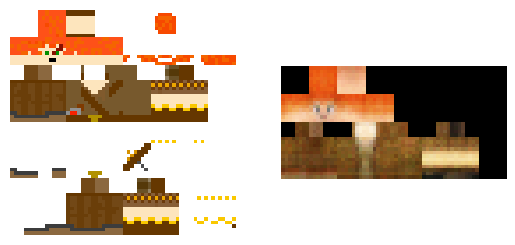

In [160]:
#feed random skins through network

path = f"data/skins/{random.randint(10,8000)}.png"
img = Image.open(path)

data = image_to_np_array(img)

input = torch.tensor(data, dtype=torch.float32)
input = input.to("cuda")

model.eval()
with torch.inference_mode():
    latent_output = model.encode(input)
    output = model.decode(latent_output)


out_img = np.zeros((32,64,3), dtype=np.uint8)
i = 0
for coords in pixel_lookup_table:
    out_img[coords[1]][coords[0]][0] = output[i]*255
    out_img[coords[1]][coords[0]][1] = output[i+1]*255
    out_img[coords[1]][coords[0]][2] = output[i+2]*255
    i += 3
out_img = Image.fromarray(out_img, mode="RGB")

fig, axes = plt.subplots(1, 2)

axes[0].imshow(img)
axes[1].imshow(out_img)
axes[0].axis("off")
axes[1].axis("off")

# axes[0].plot(np.sort(latent_output.cpu().numpy()))
plt.show()


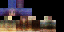

In [161]:
#generate random skins

factor = 1
for n in range(30):
    input = torch.rand(128) * 2 * factor - factor
    input = input.to("cuda")

    model.eval()
    with torch.inference_mode():
        output = model.decode(input)

    image = array_to_image(output)
    image.save(f"data/generated_outputs/{n}.png")
    
image


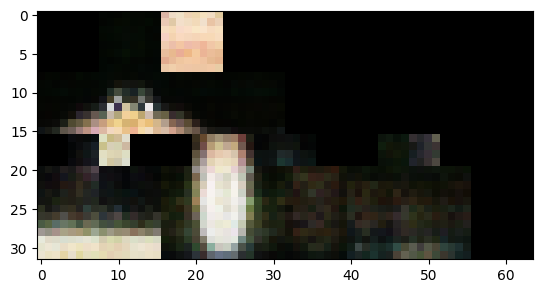

In [125]:
#feed skin through network

myskin = Image.open("data/skin2.png")
myskin_data = image_to_np_array(myskin)

input = torch.tensor(myskin_data, dtype=torch.float32, device="cuda")
model.eval()
with torch.inference_mode():
    output = model(input)

out_myskin = array_to_image(output)
# out_myskin.save("data/out_skin1.png")
plt.imshow(out_myskin)
plt.show()

---
# Scatterplot latent spaces

In [6]:
#load images

paths = []
for p in Path("data/skins").rglob("*.png"):
    paths.append(p)

input_data = []
for path_i in range(len(paths)):
    path = paths[path_i]
    image = Image.open(path)

    n_data = image_to_np_array(image)

    input_data.append(n_data)

    progress_bar(round(100*path_i/len(paths),1), length=40, text="Data loading progress: ")
progress_bar(100, length=40, text="Data loading progress: ")
print()

Data loading progress: [████████████████████████████████████████] 100%%


In [7]:
#get latent spaces
latent_space_data = []

model.eval()
with torch.inference_mode():
    i = 0
    for input in input_data:
        i+=1
        output = model.encode(torch.tensor(input, dtype=torch.float32, device="cuda"))
        output = output.cpu().numpy()
        latent_space_data.append(output)   
        progress_bar(round(100*i/len(input_data),1), length=40, text="feed input through model progress: ")
progress_bar(100, length=40, text="feed input through model progress: ")
print()

feed input through model progress: [████████████████████████████████████████] 100%%


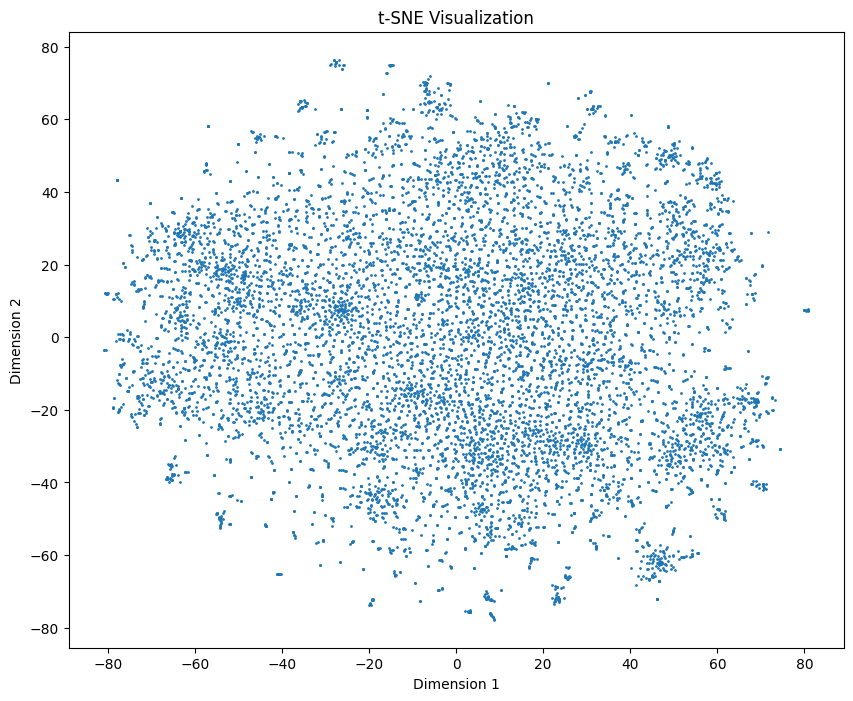

In [118]:
# downscale dimension of latent spaces

# tsne = TSNE(n_components=2)
# tsne_data = tsne.fit_transform(np.array(latent_space_data))
with open("data/tsne_data.pkl", "rb") as file:
    tsne_data = pickle.load(file)

pca = PCA(n_components=2)
reduced_vector = pca.fit_transform(np.array(latent_space_data))

plt.figure(figsize=(10, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=1)
# plt.scatter(reduced_vector[:, 0], reduced_vector[:, 1], s=0.1)
plt.title("t-SNE Visualization")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

# with open("data/latent_space_data.pkl", "wb") as file:
#     pickle.dump(latent_space_data, file)
# with open("data/tsne.pkl", "wb") as file:
#     pickle.dump(tsne, file)
# with open("data/tsne_data.pkl", "wb") as file:
#     pickle.dump(tsne_data, file)
